# Check if we can get trigger codes from openBCI GUI recording

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mne 

from glob import glob  

In [2]:
# data_files = glob('./*data/*19.txt')
data_files = glob('./*data/*RAW*.txt')
print(data_files)

['.\\Cyton_data\\OpenBCI-RAW-2025-12-10_16-50-25.txt']


In [3]:
# df = pd.concat([pd.read_csv(f, skiprows=4) for f in data_files], ignore_index=True)

df = pd.read_csv(data_files[0], skiprows=4, skipinitialspace=True)#.reset_index()

In [4]:
df.drop(columns=["Not Used", "Not Used.1", "Accel Channel 0", "Accel Channel 1", "Accel Channel 2", "Analog Channel 0", "Analog Channel 1", "Analog Channel 2"], inplace=True)
df.columns

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)',
       'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)',
       'Digital Channel 4 (D18)', 'Timestamp', 'Marker Channel',
       'Timestamp (Formatted)'],
      dtype='object')

<Axes: >

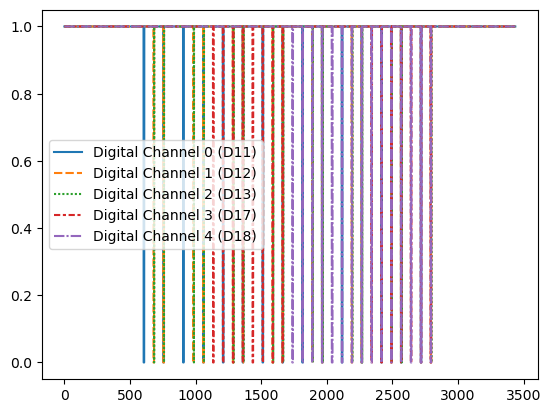

In [5]:
sfreq = 250
ch_names = df.columns[1:].tolist()

digi_cols = [col for col in ch_names if col.startswith('Digital')]

digi_df = df[digi_cols]

sns.lineplot(data=digi_df)

In [ ]:
# Get the 5 digital channels (assuming they correspond to the 5 trigger pins)
# The digital channels should be in order: D11, D12, D13, D17, D18 (or similar)
digi_cols = [col for col in df.columns if col.startswith('Digital')]
print(f"Digital channels found: {digi_cols}")

# Create a function to decode 5-bit trigger codes
def decode_trigger_codes(digi_df):
    """
    Decode 5-bit trigger codes from digital channels.
    Each row's digital channels represent bits 0-4 of the trigger code.
    Returns a Series with the decoded trigger code (0-31) for each sample.
    """
    # Convert to boolean/binary
    binary_df = (~digi_df.astype(bool)).astype(int) #digi_df.astype(bool).astype(int)
    
    # For reverse mapping (if needed)
    # trigger_codes = (
    #     binary_df.iloc[:, 0] * (2**4) +
    #     binary_df.iloc[:, 1] * (2**3) +
    #     binary_df.iloc[:, 2] * (2**2) +
    #     binary_df.iloc[:, 3] * (2**1) +
    #     binary_df.iloc[:, 4] * (2**0)
    # )
    
    # Combine the 5 bits into a single code (0-31)
    # Assuming columns are ordered from LSB to MSB (bit 0 to bit 4)
    trigger_codes = (
        binary_df.iloc[:, 0] * (2**0) +
        binary_df.iloc[:, 1] * (2**1) +
        binary_df.iloc[:, 2] * (2**2) +
        binary_df.iloc[:, 3] * (2**3) +
        binary_df.iloc[:, 4] * (2**4)
    )
    
    return trigger_codes

# decode_trigger_codes(digi_df)


Digital channels found: ['Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)', 'Digital Channel 4 (D18)']


In [20]:
test = df[digi_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

In [27]:
test

,Digital Channel 0 (D11),Digital Channel 1 (D12),Digital Channel 2 (D13),Digital Channel 3 (D17),Digital Channel 4 (D18)
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
3432,1,1,1,1,1
3433,1,1,1,1,1
3434,1,1,1,1,1
3435,1,1,1,1,1


In [ ]:
t_df = (~digi_df.astype(bool)).astype(int)

t_df['Trigger_Code'] = ()

,Digital Channel 0 (D11),Digital Channel 1 (D12),Digital Channel 2 (D13),Digital Channel 3 (D17),Digital Channel 4 (D18)
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
3432,0,0,0,0,0
3433,0,0,0,0,0
3434,0,0,0,0,0
3435,0,0,0,0,0


# Decode triggers and add as a column

In [ ]:
sorted(df['Trigger_Code'].unique())


Found 3437 trigger events found


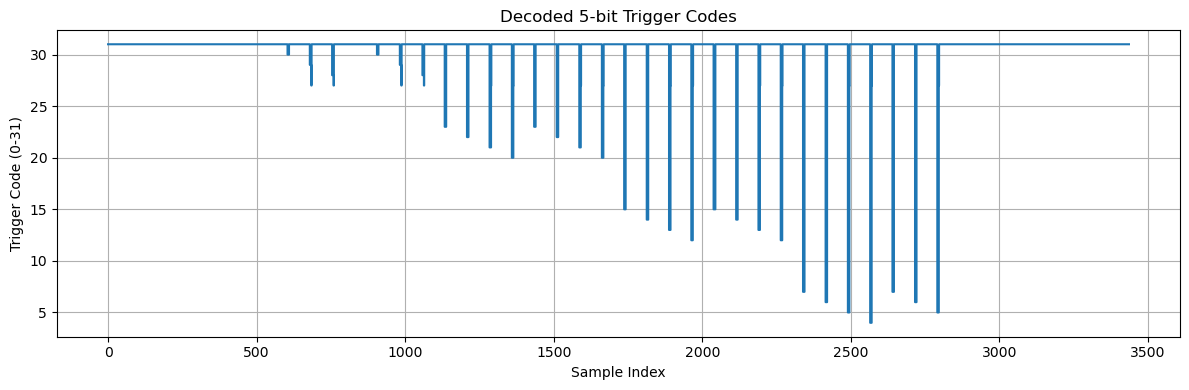

In [29]:
# Decode the trigger codes
df['Trigger_Code'] = decode_trigger_codes(digi_df)

# Find non-zero trigger events
trigger_events = df[df['Trigger_Code'] > 0][['Trigger_Code']]
print(f"\nFound {len(trigger_events)} trigger events found")
# print("\nTrigger codes detected:")
# print(trigger_events['Trigger_Code'].value_counts().sort_index())

# Plot the trigger codes over time
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Trigger_Code'], drawstyle='steps-post')
plt.xlabel('Sample Index')
plt.ylabel('Trigger Code (0-31)')
plt.title('Decoded 5-bit Trigger Codes')
plt.grid(True)
plt.tight_layout()
plt.show()

## Add a `trigger_present` column to indicate if any trigger is present 

In [ ]:
df

In [ ]:
# Create a column with trigger codes, showing NaN where code is 0
df['Trigger_Present'] = df['Trigger_Code'].replace(0, np.nan)

# Or if you want to keep the column but only show values > 0
df['Trigger_Present'] = df['Trigger_Code'].where(df['Trigger_Code'] > 0)

# View the result
print("Samples with triggers present:")
print(df[df['Trigger_Present'].notna()][['Trigger_Code', 'Trigger_Present']])


# Plot to verify
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Trigger_Present'], 'o', markersize=2, label='Triggers Present')
plt.xlabel('Sample Index')
plt.ylabel('Trigger Code')
plt.title('Trigger Codes (only where present)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()